In [66]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import json
import pandas as pd
from evaluation import evaluation
import copy

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 3, "Early NPDR": 1, "Late NPDR": 2}
label_names = ["Healthy/DM", "Early NPDR","Late NPDR", "PDR"]

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"


mode_train = "all"
full_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_train}_dataset.pkl"
full_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_train,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = full_pickle
                                                        )

full_dataset.update_class(octa_dr_dict)
# number of classes are the unique labels the octa_dr_dict
num_classes = len(np.unique(list(octa_dr_dict.values())))
# imputation can be done in advance for all the data
prep.hetero_graph_imputation(full_dataset)
# adding graph features can be done in advance for all the data
prep.add_node_features(full_dataset, ["graph_1", "graph_2"])

# adding global node could be done in advance
#prep.add_global_node(full_dataset)

In [15]:

# split the data into an holdout and use the rest for cross validation
y_data = [data.y.detach().numpy()[0] for data in full_dataset.hetero_graph_list]
# the test graphs are used as holdout, the rest is used for cross validation
train_dataset, test_dataset, train_y, test_y = train_test_split(full_dataset.hetero_graph_list, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [17]:


node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(train_dataset)


prep.hetero_graph_normalization(train_dataset, node_mean_tensors, node_std_tensors)
prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)


In [19]:
# read the feature_name_dict.json
with open("../feature_name_dict.json", "r") as file:
    label_dict_full = json.load(file)
    #features_label_dict = json.load(file)
features_label_dict = copy.deepcopy(label_dict_full)


train_dataset_work = copy.deepcopy(train_dataset)
test_dataset_work = copy.deepcopy(test_dataset)

#eliminate_features = {"graph_1":["num_voxels", "maxRadiusAvg", "hasNodeAtSampleBorder", "maxRadiusStd"], 
#                      "graph_2":["centroid-0", "centroid-1", "orientation","solidity"]} # "feret_diameter_max", "equivalent_diameter",  #"centroid_weighted-0", "centroid_weighted-1", 
#
#for key in eliminate_features.keys():
#    for feat in eliminate_features[key]:
#        idx = features_label_dict[key].index(feat)
#        features_label_dict[key].remove(feat)
#        for data in train_dataset_work:
#            data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
#        for data in test_dataset_work:
#            data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)



In [20]:
# load the feature label 
# just for the first graph

x_train = np.zeros((len(train_dataset_work), len(features_label_dict["graph_1"]) + len(features_label_dict["graph_2"])))
y_train = np.zeros((len(train_dataset_work),))
x_test = np.zeros((len(test_dataset_work), len(features_label_dict["graph_1"]) + len(features_label_dict["graph_2"])))
y_test = np.zeros((len(test_dataset_work),))




for i in range(len(train_dataset_work)):
    graph_1 = train_dataset_work[i]["graph_1"]
    graph_2 = train_dataset_work[i]["graph_2"]

    y_train[i] = train_dataset_work[i].y
    
    # average the features of all nodes in the graph 
    graph_1_avg = graph_1.x.numpy().mean(axis = 0)
    graph_2_avg = graph_2.x.numpy().mean(axis = 0)

    # add averages to the matrix
    x_train[i,:len(features_label_dict["graph_1"])] = graph_1_avg
    x_train[i,len(features_label_dict["graph_1"]):] = graph_2_avg

for i in range(len(test_dataset_work)):
    graph_1 = test_dataset_work[i]["graph_1"]
    graph_2 = test_dataset_work[i]["graph_2"]

    y_test[i] = test_dataset_work[i].y
    
    # average the features of all nodes in the graph 
    graph_1_avg = graph_1.x.numpy().mean(axis = 0)
    graph_2_avg = graph_2.x.numpy().mean(axis = 0)

    # add averages to the matrix
    x_test[i,:len(features_label_dict["graph_1"])] = graph_1_avg
    x_test[i,len(features_label_dict["graph_1"]):] = graph_2_avg


In [71]:
param_grid_rf = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 
param_grid_rf = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter':['best', 'random'], 'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced', None]}


rf_classifier = DecisionTreeClassifier()


# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store predictions and scores for each fold
all_predictions = []
all_test_accuracy = []
all_test_balanced_accuracy = []
all_test_kappa = []

# Loop through the folds
for train_index, test_index in cv.split(x_train, y_train):
    X_fold_train, X_fold_val = x_train[train_index], x_train[test_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[test_index]

    # Set up GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='balanced_accuracy')

    # Fit the GridSearchCV on the training data of this fold
    grid_search.fit(X_fold_train, y_fold_train)

    # Get the best model from this fold
    best_model = grid_search.best_estimator_

    # Predict on the external test set for this fold
    y_pred_test = best_model.predict(x_test)

    # Evaluate on the external test set
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
    test_kappa = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

    print(test_balanced_accuracy)

    # Store predictions and scores
    all_predictions.append(y_pred_test)
    all_test_accuracy.append(test_accuracy)
    all_test_balanced_accuracy.append(test_balanced_accuracy)
    all_test_kappa.append(test_kappa)

0.4820406201985149
0.47677870375238796
0.4429988870778344
0.44753857253857254
0.477460405091984


RF:
0.5517888544204334
0.5069031845347635
0.5475595311121627
0.5321166406692722
0.4558752650857914
Mean External Test Set Balanced Accuracy: 0.5188 +/- 0.0352
Mean External Test Set Accuracy: 0.7147 +/- 0.0090
Mean External Test Set Kappa: 0.6286 +/- 0.0090



Decision Tree:
0.47734173721015827
0.4538717861086282
0.4190681394628763
0.5202801584380532
0.43441061862114494
Mean External Test Set Balanced Accuracy: 0.4654 +/- 0.0166
Mean External Test Set Accuracy: 0.6233 +/- 0.0925
Mean External Test Set Kappa: 0.5478 +/- 0.0408

In [72]:

# Print results for each fold
#for i, test_score in enumerate(all_test_balanced_accuracy):
#    print(f'Fold {i+1} - External Test Set Balanced Accuracy: {test_score:.4f}')

# Overall performance
mean_test_balanced_accuracy = np.mean(all_test_balanced_accuracy)
std_test_balanced_accuracy = np.std(all_test_balanced_accuracy)
print(f'Mean External Test Set Balanced Accuracy: {mean_test_balanced_accuracy:.4f} +/- {std_test_balanced_accuracy:.4f}')

mean_test_accuracy = np.mean(all_test_accuracy)
std_test_accuracy = np.std(all_test_accuracy)
print(f'Mean External Test Set Accuracy: {mean_test_accuracy:.4f} +/- {std_test_accuracy:.4f}')

mean_test_kappa = np.mean(all_test_kappa)
std_test_kappa = np.std(all_test_kappa)
print(f'Mean External Test Set Kappa: {mean_test_kappa:.4f} +/- {std_test_kappa:.4f}')

Mean External Test Set Balanced Accuracy: 0.4654 +/- 0.0166
Mean External Test Set Accuracy: 0.6233 +/- 0.0925
Mean External Test Set Kappa: 0.5478 +/- 0.0408


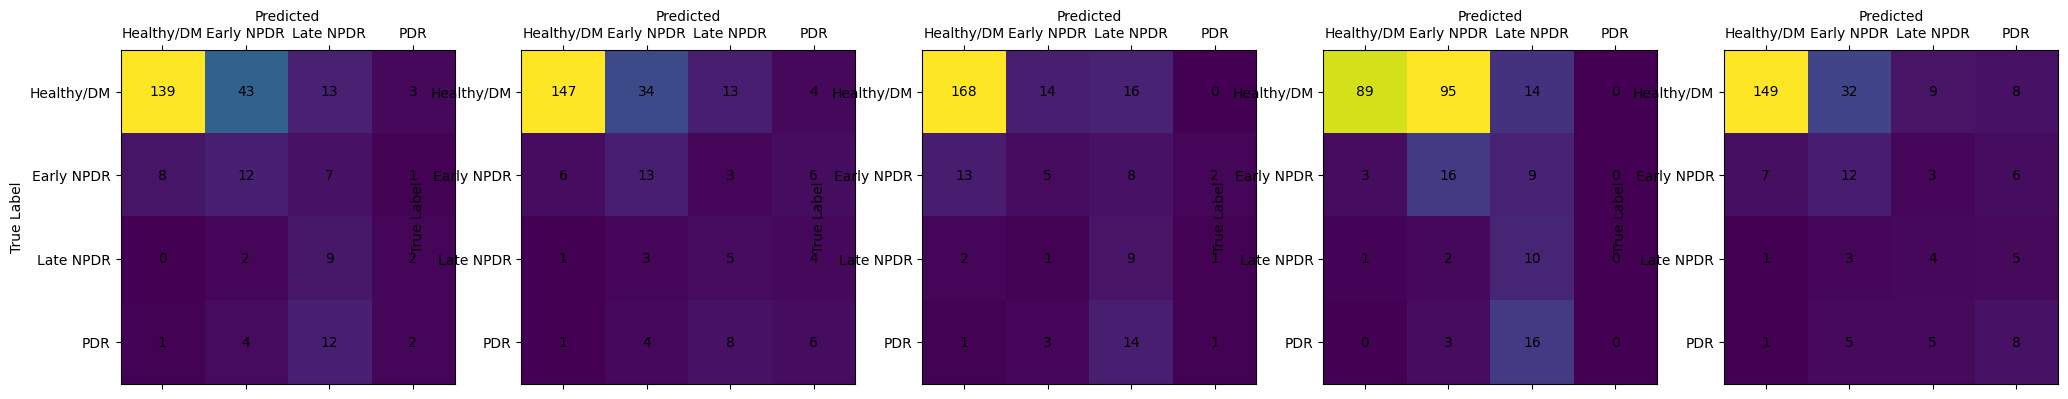

In [73]:
fig, ax = plt.subplots(1, 5, figsize = (25, 8))
for i, pred in enumerate(all_predictions):
    evaluation.plot_confusion_matrix(y_test, pred, label_names, ax[i])

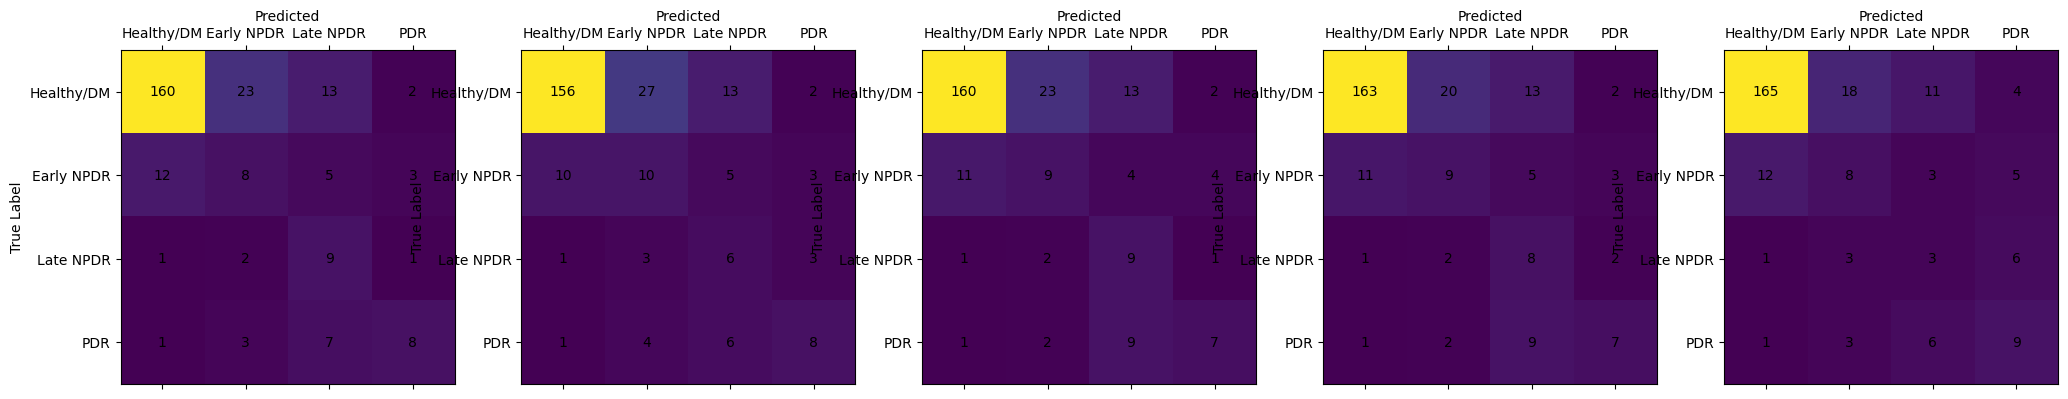

In [65]:
fig, ax = plt.subplots(1, 5, figsize = (25, 8))
for i, pred in enumerate(all_predictions):
    evaluation.plot_confusion_matrix(y_test, pred, label_names, ax[i])